# Draw an image full of circles of which arcs make up the original image 

## Example showing the desired output

![title](desired_image.jpg)

## 4. Subproblem: Create gradient background

## 0. Subproblem: Select the right tools

[Cairo](https://www.cairographics.org/documentation/) seems the right choice regarding drawing while using numpy arrays as base for its drawing.

### Create background image sample

In [478]:
import numpy as np
import matplotlib.pyplot as plt
import cairo
import math
import imageio
import scipy.ndimage
import scipy.signal
from skimage.color import rgb2grayfirst_circle[0]
import cv2 as cv

import pdb

In [479]:

def plot_image(image):
    plt.imshow(image.astype(np.uint8))
#     plt.axis('off')
    
    plt.show()

background = np.zeros((200, 200, 4), dtype=np.uint8)
surface = cairo.ImageSurface.create_for_data(
    background, cairo.FORMAT_ARGB32, 200, 200)

cr = cairo.Context(surface)

cr.set_source_rgba(1.0, 1.0, 1.0, 1)
cr.paint()

# cr.arc(100, 100, 80, 0, 2*math.pi)
# cr.set_line_width(3)
# cr.set_source_rgb(1.0, 0.0, 0.0)
# cr.stroke()

# print(background)
surface.write_to_png("circle.png")

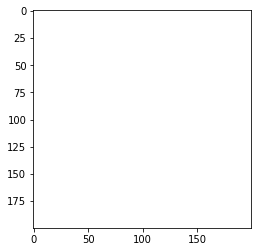

In [480]:
plot_image(background)

## 1. Subproblem: Draw a circle through two points

In [481]:
cr.set_source_rgba(1, 0.2, 0.2, 0.6)

p1_x = 50
p1_y = 50

p2_x = 50
p2_y = 150

cr.arc (p1_x, p1_y, 4.0, 0, 2*np.pi)
cr.arc (p2_x, p2_y, 4.0, 0, 2*np.pi)
cr.fill ();

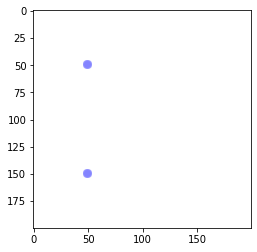

In [482]:
plot_image(background)

In [483]:
def circles_from_p1p2r(p1, p2, r):
    'Following explanation at http://mathforum.org/library/drmath/view/53027.html'
    if r == 0.0:
        raise ValueError('radius of zero')
    (x1, y1), (x2, y2) = p1, p2
    if p1 == p2:
        raise ValueError('coincident points gives infinite number of Circles')
    # delta x, delta y between points
    dx, dy = x2 - x1, y2 - y1
    # dist between points
    q = math.sqrt(dx**2 + dy**2)
    if q > 2.0*r:
        raise ValueError('separation of points > diameter')
    # halfway point
    x3, y3 = (x1+x2)/2, (y1+y2)/2
    # distance along the mirror line
    d = math.sqrt(r**2-(q/2)**2)
    # One answer
    c1 = (x3 - d*dy/q,
          y3 + d*dx/q,
          abs(r))
    # The other answer
    c2 = (x3 + d*dy/q,
          y3 - d*dx/q,
          abs(r))
    return c1, c2

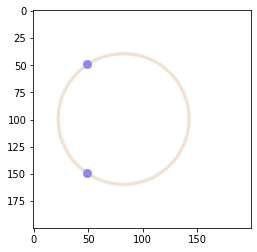

In [484]:
c1, c2 = circles_from_p1p2r((p1_x, p1_y), (p2_x, p2_y), 60.0)

# cr.arc(c1[0], c1[1], c1[2], 0, 2*math.pi)
# cr.set_line_width(3)
# cr.set_source_rgb(1.0, 0.0, 0.0)
# cr.stroke()

cr.arc(c2[0], c2[1], c2[2], 0, 2*math.pi)
cr.set_line_width(3)
cr.set_source_rgba(0.4, 0.6, 0.8, 0.3)
cr.stroke()

plot_image(background)

In [485]:
print(background[:,:,0])
print(np.unique(background))
background[:,:,3] = 28
print(background[:,:,3])

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[132 133 134 135 136 137 138 139 140 141 142 143 144 146 148 149 150 151
 152 153 154 156 162 163 165 167 169 170 171 172 177 178 207 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255]
[[28 28 28 ... 28 28 28]
 [28 28 28 ... 28 28 28]
 [28 28 28 ... 28 28 28]
 ...
 [28 28 28 ... 28 28 28]
 [28 28 28 ... 28 28 28]
 [28 28 28 ... 28 28 28]]


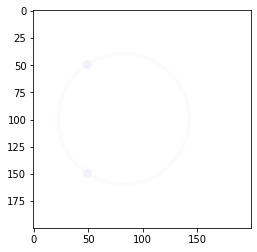

In [486]:
plot_image(background)

In [487]:
surface.write_to_png("circle.png")
surface2 = cairo.ImageSurface.create_for_data(
    background, cairo.FORMAT_ARGB32, 200, 200)

In [488]:
surface2.write_to_png("circle2.png")

## 2. Subproblem: Select which circle to draw (lefside/rightside or up/down) and increase opacity over the arc

In [489]:
def point_closer_to(ref_point, point1, point2):
    (ref_point_x, ref_point_y) = ref_point
    
    point1_x, point1_y = point1[0], point1[1]
    point2_x, point2_y = point2[0], point2[1]
    
    delta_x1, delta_y1 = ref_point_x - point1_x, ref_point_y - point1_y
    delta_x2, delta_y2 = ref_point_x - point2_x, ref_point_y - point2_y
    
    distance1 = math.sqrt(delta_x1**2 + delta_y1**2)
    distance2 = math.sqrt(delta_x2**2 + delta_y2**2)
    
    if distance1 < distance2:
        return point1
    else:
        return point2

# to-do: must select which cirlce more cleverly
def get_circle(point1, point2, radius, image_shape):
    if radius == 0.0:
        raise ValueError('radius of zero')
    
    (point1_x, point1_y), (point2_x, point2_y) = point1, point2
    
    if point1 == point2:
        raise ValueError('coincident points gives infinite number of Circles')
    
    # delta x, delta y between points
    delta_x, delta_y = point2_x - point1_x, point2_y - point1_y
    # dist between points
    distance_points = math.sqrt(delta_x**2 + delta_y**2)
    
    if distance_points > 2.0 * radius:
        raise ValueError('separation of points > diameter')
    
    # halfway point
    point3_x, point3_y = (point1_x + point2_x) / 2, (point1_y + point2_y) / 2
    
    # distance along the mirror line
    distance_mirror = math.sqrt(radius**2 - (distance_points / 2)**2)
    
    # One answer
    left_circle = (point3_x - distance_mirror * delta_y / distance_points,
                   point3_y + distance_mirror * delta_x / distance_points,
                   abs(radius))
    # The other answer
    right_circle = (point3_x + distance_mirror * delta_y / distance_points,
                    point3_y - distance_mirror * delta_x / distance_points,
                    abs(radius))

    image_center = image_shape[0] / 2, image_shape[1] / 2
    
    circle = point_closer_to(image_center, left_circle, right_circle)
    
    return circle

In [490]:
point1 = (80, 30)
point2 = (130, 50)

background = np.zeros((200, 200, 4), dtype=np.uint8)
main_surface = cairo.ImageSurface.create_for_data(
    background, cairo.FORMAT_ARGB32, 200, 200)

cr = cairo.Context(main_surface)

# draw background
cr.set_source_rgba(1.0, 1.0, 1.0, 1)
cr.paint()

# draw the two points
cr.set_source_rgba(1, 0.2, 0.2, 0.6)
cr.arc(point1[0], point1[1], 4.0, 0, 2*np.pi)
cr.arc(point2[0], point2[1], 4.0, 0, 2*np.pi)
cr.fill()

# save the image
main_surface.write_to_png("points.png")

In [491]:
circle = get_circle(point1, point2, 60, background.shape)

# draw the circle
cr.set_source_rgba(1, 0.2, 0.2, 0.1)
cr.arc(circle[0], circle[1], circle[2], 0, 2*math.pi)
cr.set_line_width(3)
cr.stroke()

main_surface.write_to_png("circle_and_points.png")

In [492]:
def quadrant(point, circle):
#     import pdb; pdb.set_trace()
    if point[0] > circle[0] and point[1] < circle[1]:
        return 1
    elif point[0] < circle[0] and point[1] < circle[1]:
        return 2
    elif point[0] < circle[0] and point[1] > circle[1]:
        return 3
    
    return 4    

# to-do: which arc must be decided cleverly
#        for now, it will depend on which side
#        the points are to the center of the image
#        (up/down and right/left)
def get_increase_opacity_angles(point1, point2, circle):
    zero_degrees_point = (circle[0] + circle[2], circle[1])
    
    # delta x, delta y between points
    delta1_x, delta1_y = zero_degrees_point[0] - point1[0], zero_degrees_point[1] - point1[1]
    delta2_x, delta2_y = zero_degrees_point[0] - point2[0], zero_degrees_point[1] - point2[1]
    # dist between points
    distance_points1 = math.sqrt(delta1_x**2 + delta1_y**2)
    distance_points2 = math.sqrt(delta2_x**2 + delta2_y**2)
    
    angle1 = np.arccos(1 - distance_points1**2/(2 * circle[2]**2))
    angle2 = np.arccos(1 - distance_points2**2/(2 * circle[2]**2))
    
    if quadrant(point1, circle) == 1:
        angle1 = np.pi/2 - angle1 + 3/2*np.pi
    elif quadrant(point1, circle) == 2:
        angle1 = 2*np.pi - angle1
    
    if quadrant(point2, circle) == 1:
        angle2 = np.pi/2 - angle2 + 3/2*np.pi
    elif quadrant(point2, circle) == 2:
        angle2 = 2*np.pi - angle2
    
    
    return min(angle1, angle2), max(angle1, angle2)

In [493]:
angle_start, angle_stop = get_increase_opacity_angles(point1, point2, circle)

# draw the circle
cr.set_source_rgba(1, 0.2, 0.2, 1)
cr.arc(circle[0], circle[1], circle[2], angle_start, angle_stop)
cr.set_line_width(3)
cr.stroke()

In [494]:
main_surface.write_to_png("circle_and_points_increased_opacity.png")

In [495]:
def distance_between(point1, point2):
    point1_x, point1_y = point1
    point2_x, point2_y = point2
    
    # delta x, delta y between points
    delta_x, delta_y = point2_x - point1_x, point2_y - point1_y
    # dist between points
    distance_points = math.sqrt(delta_x**2 + delta_y**2)
    
    return distance_points

In [496]:
background = np.zeros((200, 200, 4), dtype=np.uint8)
main_surface = cairo.ImageSurface.create_for_data(
    background, cairo.FORMAT_ARGB32, 200, 200)

cr = cairo.Context(main_surface)

# draw background
cr.set_source_rgba(1.0, 1.0, 1.0, 1)
cr.paint()

# draw the two points
point1 = (160, 130)
point2 = (30, 150)

distance1 = distance_between(point1, point2)

cr.set_source_rgba(1, 0.2, 0.2, 0.6)
cr.arc(point1[0], point1[1], 4.0, 0, 2*np.pi)
cr.arc(point2[0], point2[1], 4.0, 0, 2*np.pi)
cr.fill()

# draw the circle
circle = get_circle(point1, point2, distance1 + 20, background.shape)
cr.set_source_rgba(1, 0.2, 0.2, 0.1)
cr.arc(circle[0], circle[1], circle[2], 0, 2*math.pi)
cr.set_line_width(3)
cr.stroke()

# increase opacity
angle_start, angle_stop = get_increase_opacity_angles(point1, point2, circle)

# draw the circle
cr.set_source_rgba(1, 0.2, 0.2, 1)
cr.arc(circle[0], circle[1], circle[2], angle_start, angle_stop)
cr.set_line_width(3)
cr.stroke()

In [497]:
# draw the two points
point3 = (80, 30)
point4 = (130, 50)

distance2 = distance_between(point3, point4)

cr.set_source_rgba(1, 0.2, 0.2, 0.6)
cr.arc(point3[0], point3[1], 4.0, 0, 2*np.pi)
cr.arc(point4[0], point4[1], 4.0, 0, 2*np.pi)
cr.fill()

# draw the circle
circle = get_circle(point3, point4, distance2 + 20, background.shape)
cr.set_source_rgba(1, 0.2, 0.2, 0.1)
cr.arc(circle[0], circle[1], circle[2], 0, 2*math.pi)
cr.set_line_width(3)
cr.stroke()

# increase opacity
angle_start, angle_stop = get_increase_opacity_angles(point3, point4, circle)

# draw the circle
cr.set_source_rgba(1, 0.2, 0.2, 1)
cr.arc(circle[0], circle[1], circle[2], angle_start, angle_stop)
cr.set_line_width(3)
cr.stroke()

# save the image
main_surface.write_to_png("big_cool.png")

## 3. Subproblem: Select the representative symmetrical(optional) points for an input image

### 3.1 Recreate simple images with hardcoded coordinates

#### Example: Square

The length of the arc replacing a line should be about some constant times the length of the line.

Let that constant be 1.2.

Problems: 

How do we draw convex figures.

How do we know which points to connect and how many connections are there.

Rule: connect a point to the closest point. If that point is already connected to the current point, connect it to the closest point which has the least connections.

In [498]:
def closest_point(point, points):
    best_dist = 4000
    chosen_point = point
    
    for current_point in points:
        if distance_between(point, current_point) < best_dist:
#             import pdb; pdb.set_trace()
            chosen_point = current_point
            best_dist = distance_between(point, current_point)
    
    return chosen_point

def chose_point(point, points, points_connections, connections):
    points.remove(point)
    not_chosen = True
    
    while not_chosen:
        chosen_point = closest_point(point, points)
#         import pdb; pdb.set_trace()
        if [point, chosen_point] not in connections:
            return chosen_point
        
        points.remove(chosen_point)
        
        if len(points) == 0:
            return point
        

In [499]:
points = [(160,160), (360,160), (360,360), (160,360)]

c_al = 1.2

connections = []
for index in range(len(points)-1):
    connections.append((points[index], points[index+1]))
    
connections.append((points[len(points)-1], points[0]))


In [500]:
def quadrant(point, circle):
#     import pdb; pdb.set_trace()
    if point[0] >= circle[0] and point[1] <= circle[1]:
        return 1
    elif point[0] <= circle[0] and point[1] <= circle[1]:
        return 2
    elif point[0] <= circle[0] and point[1] >= circle[1]:
        return 3
    
    return 4    
# to-do: which arc must be decided cleverly
#        for now, it will depend on which side
#        the points are to the center of the image
#        (up/down and right/left)
def get_increase_opacity_angles(point1, point2, circle):
    zero_degrees_point = (circle[0] + circle[2], circle[1])
    
    # delta x, delta y between points
    delta1_x, delta1_y = zero_degrees_point[0] - point1[0], zero_degrees_point[1] - point1[1]
    delta2_x, delta2_y = zero_degrees_point[0] - point2[0], zero_degrees_point[1] - point2[1]
    # dist between points
    distance_points1 = math.sqrt(delta1_x**2 + delta1_y**2)
    distance_points2 = math.sqrt(delta2_x**2 + delta2_y**2)
    
    angle1 = np.arccos(1 - distance_points1**2/(2 * circle[2]**2))
    angle2 = np.arccos(1 - distance_points2**2/(2 * circle[2]**2))
    
    if quadrant(point1, circle) == 1:
        angle1 = np.pi/2 - angle1 + 3/2*np.pi
    elif quadrant(point1, circle) == 2:
        angle1 = 2*np.pi - angle1
    
    if quadrant(point2, circle) == 1:
        angle2 = np.pi/2 - angle2 + 3/2*np.pi
    elif quadrant(point2, circle) == 2:
        angle2 = 2*np.pi - angle2
    
    if ((quadrant(point1, circle) == 1 and quadrant(point2, circle) == 4) or
       (quadrant(point2, circle) == 1 and quadrant(point1, circle) == 4)):
        return max(angle1, angle2), min(angle1, angle2)
    
    
    return min(angle1, angle2), max(angle1, angle2)

In [501]:
def get_circle(point1, point2, scale_const, image_shape):
    (point1_x, point1_y), (point2_x, point2_y) = point1, point2

    if point1 == point2:
        raise ValueError('coincident points gives infinite number of Circles')
    
    # delta x, delta y between points
    delta_x, delta_y = point2_x - point1_x, point2_y - point1_y
    # dist between points
    distance_points = math.sqrt(delta_x**2 + delta_y**2)
    
    # scaling radius selected, scale_const must be bigger than 0.5
    radius = scale_const * distance_points
    if scale_const < 0.5:
        raise ValueError('separation of points > diameter')
    
    # halfway point
    point3_x, point3_y = (point1_x + point2_x) / 2, (point1_y + point2_y) / 2
    
    # distance along the mirror line
    distance_mirror = math.sqrt(radius**2 - (distance_points / 2)**2)
    
    # One answer
    left_circle = (point3_x - distance_mirror * delta_y / distance_points,
                   point3_y + distance_mirror * delta_x / distance_points,
                   abs(radius))
    # The other answer
    right_circle = (point3_x + distance_mirror * delta_y / distance_points,
                    point3_y - distance_mirror * delta_x / distance_points,
                    abs(radius))

    image_center = image_shape[0] / 2, image_shape[1] / 2
    
    circle = point_closer_to(image_center, left_circle, right_circle)
    
    return circle

In [502]:
def create_circle_layer(surface_shape, points, radius_scale):
    width, height, channels = surface_shape
    
    background = np.zeros((width, height, channels), dtype=np.uint8)
    main_surface = cairo.ImageSurface.create_for_data(
        background, cairo.FORMAT_ARGB32, width, height)

    cr = cairo.Context(main_surface)

    # draw background
    cr.set_source_rgba(1.0, 1.0, 1.0, 1)
    cr.paint()

    # draw the two points
    point1 = points[0]
    point2 = points[1]

#     cr.set_source_rgba(1, 0.2, 0.2, 0.6)
#     cr.arc(point1[0], point1[1], 4.0, 0, 2*np.pi)
#     cr.arc(point2[0], point2[1], 4.0, 0, 2*np.pi)
#     cr.fill()

    # draw the circle
    circle = get_circle(point1, point2, radius_scale, background.shape)
    cr.set_source_rgba(1, 0.2, 0.2, 0.1)
    cr.arc(circle[0], circle[1], circle[2], 0, 2*math.pi)
    cr.set_line_width(3)
    cr.stroke()

    # increase opacity
    angle_start, angle_stop = get_increase_opacity_angles(point1, point2, circle)
#     pdb.set_trace()
    
    # draw the circle
    cr.set_source_rgba(1, 0.2, 0.2, 1)
    cr.arc(circle[0], circle[1], circle[2], angle_start, angle_stop)
    cr.set_line_width(3)
    cr.stroke()
    
    return background

In [503]:
def draw_image(connections, image_shape, radius_scale):
    print(image_shape)
    width, height, channels = image_shape
    
    background = np.zeros(image_shape, dtype=np.uint8)
    main_surface = cairo.ImageSurface.create_for_data(
        background, cairo.FORMAT_ARGB32, width, height)

    cr = cairo.Context(main_surface)

    # draw background
    cr.set_source_rgba(1.0, 1.0, 1.0, 1)
    cr.paint()
    
    for connection in connections:
        circle_layer = create_circle_layer(image_shape, connection, radius_scale)
        
        background += circle_layer
    
    return background, main_surface

image, surface = draw_image(connections, (520, 520, 4), 0.95)
        
# plot_image(image)
surface.write_to_png("square.png")

(520, 520, 4)


For the input below, we must first smooth the contour and then find some point in order to create our connections for the circles.

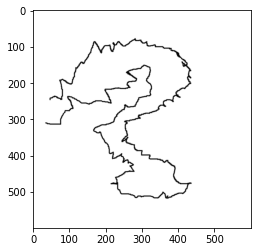

In [504]:
input_image = imageio.imread("noised_contour.png")
plot_image(input_image)

(600, 600, 4)
(600, 600, 3)
(600, 600)


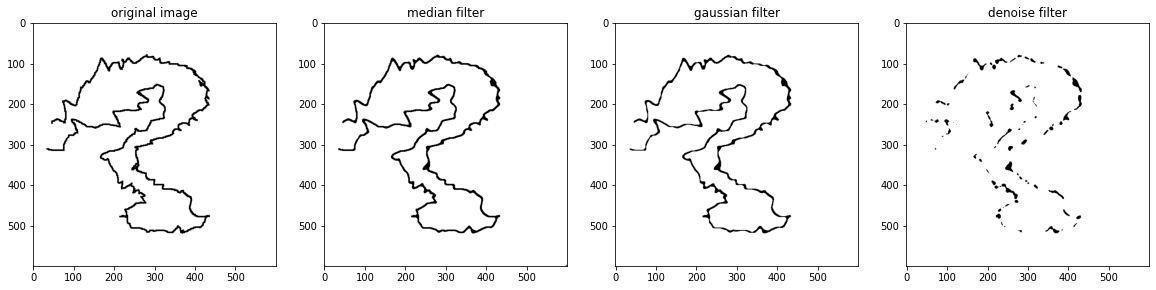

In [505]:
input_image = np.array(input_image)
print(input_image.shape)
gray_image = input_image[:,:,:3]
print(gray_image.shape)
gray_image = rgb2gray(gray_image).astype(np.uint8)

print(gray_image.shape)

median = scipy.signal.medfilt(gray_image, 7)
gaussian = cv.GaussianBlur(gray_image, (11,11), 3)
denoise = cv.fastNlMeansDenoising(gray_image, None, 30, 3, 11)

plt.figure(figsize=(20,15))

plt.subplot(141)
plt.imshow(gray_image, cmap='gray')
plt.title("original image")

plt.subplot(142)
plt.imshow(median, cmap='gray')
plt.title("median filter")

plt.subplot(143)
plt.imshow(gaussian, cmap='gray')
plt.title("gaussian filter")

plt.subplot(144)
plt.imshow(denoise, cmap='gray')
plt.title("denoise filter")

plt.show()

Give up smoothing for now, let's try to find contours and interpolate the points.

[425, 386, 349, 314, 281, 250, 221, 194, 169, 146, 125, 106, 89, 74, 61, 50, 41, 34, 29, 26, 25, 26, 29, 34, 41, 50, 61, 74, 89, 106, 125, 146, 169, 194, 221, 250, 281, 314, 349, 386]
[34, 89, 146, 281, 194, 281, 250, 74, 74, 146, 425, 25, 125, 106, 250, 386, 26, 61, 349, 314, 314, 194, 125, 26, 50, 169, 41, 89, 41, 221, 169, 34, 50, 29, 349, 106, 221, 29, 386, 61]
-46.368358400000204


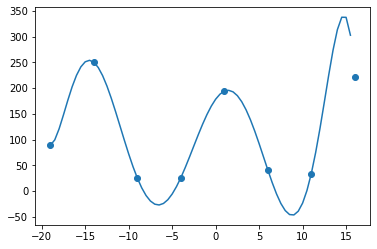

In [506]:
from scipy.interpolate import KroghInterpolator
import random

x=range(-20,20)
y=[]
for i in x:
    y.append((i**2)+25)

print(y)
random.shuffle(y)
print(y)

x=x[1::5]
y=y[1::5]

f=KroghInterpolator(x,y)
xfine=np.arange(min(x),max(x),.5)
yfine=f(xfine)

val_interp=min(yfine)
print(val_interp)

plt.scatter(x,y)
plt.plot(xfine, yfine)
plt.show()

1


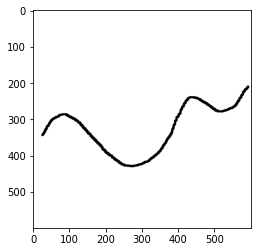

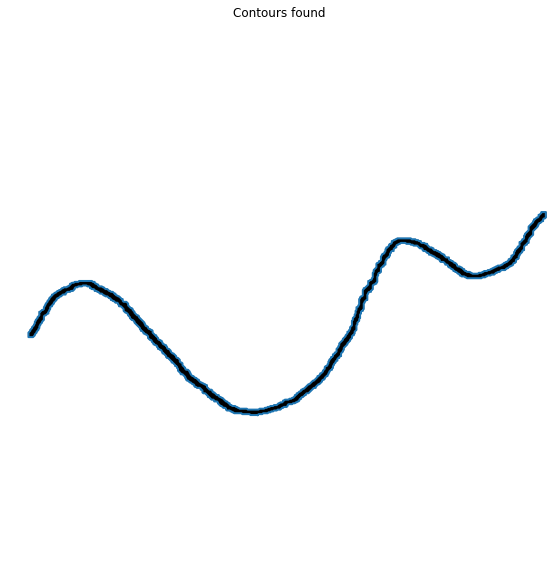

In [507]:
from skimage import measure

original_image = imageio.imread("medium.png")
original_image = rgb2gray(original_image[:,:,:3]).astype(np.uint8)

plt.imshow(original_image, cmap='gray')

contours = measure.find_contours(original_image, 
                                 0, 
                                 fully_connected='high',
                                 positive_orientation='low')

print(len(contours))

plt.figure(figsize=(10, 10))
plt.imshow(original_image, cmap='gray')
for _, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.title('Contours found')
plt.axis('off')

plt.show()

In [508]:
print(contours[0][0])

[432. 276.]


572
197
572
572
-1.7596228574968451e+49


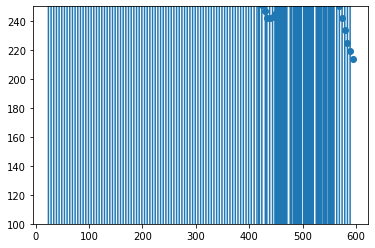

In [565]:
from collections import defaultdict

oX = [x[1] for x in contours[0]]
oY = [x[0] for x in contours[0]]

duplicates = defaultdict(list)
for index, x in enumerate(oX):
    duplicates[x].append(index)

good_indexes = []
for x, indexes in sorted(duplicates.items()):
    good_indexes.append(indexes[0])
      
new_oX = []
new_oY = []
for index in good_indexes:
    new_oX.append(oX[index])
    new_oY.append(oY[index])
        
print(len(new_oY))
print(len(np.unique(new_oY)))
print(len(new_oX))
print(len(np.unique(new_oX)))

x = new_oX
y = new_oY

all_points = list(zip(x,y))

x=new_oX[1::5]
y=new_oY[1::5]

f=KroghInterpolator(x,y)
xfine=np.arange(min(x),max(x),.5)
yfine=f(xfine)

val_interp=min(yfine)
print(val_interp)

plt.scatter(x,y)
plt.plot(xfine, yfine)
plt.ylim(100, 250)
plt.show()

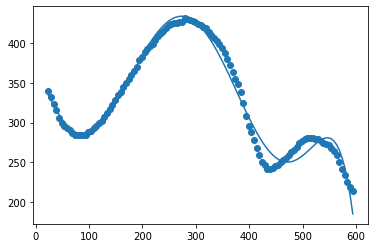

In [566]:
z = np.polyfit(x, y, 7)
p = np.poly1d(z)

plt.scatter(x,y)
plt.plot(x, p(x))

## Random version of connections selection

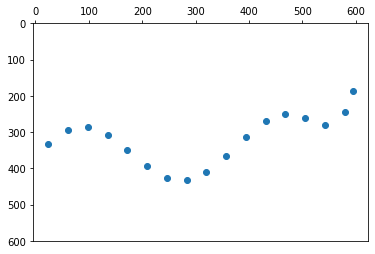

In [545]:
new_x = np.arange(min(x), max(x), random.randint(0, 100))
new_x = np.append(new_x, max(x))
new_y = p(new_x)

points = list(zip(new_x, new_y))

connections = []
for index in range(len(points)-1):
    connections.append((points[index], points[index+1]))

def scatter_reverse_y(x, y):
    plt.figure()
    plt.scatter(x, y)
    ax = plt.gca()                          # get the axis
    ax.set_ylim(0, 600)
    ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()                    # remove right y-Ticks

scatter_reverse_y(new_x, new_y)

(600, 600, 4)


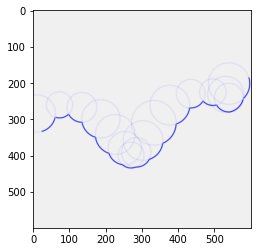

In [546]:
image, surface = draw_image(points, connections, (600, 600, 4), 0.95)

surface.write_to_png("easy_random.png")
plot_image(image)

points = []

## Kneed version of connections selection

In [547]:
from kneed import KneeLocator

new_x = np.arange(min(x), max(x), 5)
new_x = np.append(new_x, max(x))
new_y = p(new_x)

searching_point_x = new_x[0]
searching_point_y = new_y[0]
points.append((searching_point_x, searching_point_y))
while len(new_x) > 10:
    kneedle = KneeLocator(new_x, new_y, S=1.0)
    
    searching_point_x = kneedle.knee
    searching_point_y = kneedle.knee_y

    points.append((searching_point_x, searching_point_y))
    
    new_x = np.arange(searching_point_x+5, max(x), 5)
    new_y = p(new_x)

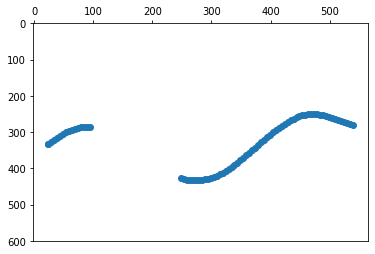

In [548]:
chosen_x, chosen_y = [[x for x, y in points],
        [y for x, y in points]]

scatter_reverse_y(chosen_x, chosen_y)

As we can see, we can't use this directly like this. Let's try a method involving local minimas&maximas.

## Local minima & maxima version of connections selection

In [549]:
from scipy.signal import argrelextrema

new_x = np.arange(min(x), max(x), 5)
new_x = np.append(new_x, max(x))
new_y = p(new_x)

minimas = argrelextrema(new_y, np.greater)
maximas = argrelextrema(new_y, np.less)

local_y = new_y[minimas[0]]
for value in new_y[maximas[0]]:
    local_y = np.append(local_y, value)

local_x = []
for value in local_y:
    for current_x in new_x:
        if int(p(current_x)) == int(value):
            local_x.append(current_x)
            break

print(local_y)
print(local_x)

[433.35529477 280.93861815 285.74892288 250.50703932]
[269.0, 544.0, 89.0, 469.0]


In [550]:
local_x.append(new_x[0])
local_x.append(max(new_x))
local_x = sorted(local_x)
print(local_x)

[24.0, 89.0, 269.0, 469.0, 544.0, 594.0]


In [551]:
local_y = [value for value in p(local_x)]
print(local_y)

[334.18804845806653, 285.74892287870165, 433.15061483048265, 250.54724338946411, 280.9386181507134, 185.52723858461783]


TypeError: draw_image() missing 1 required positional argument: 'radius_scale'

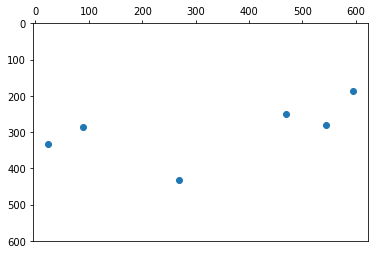

In [552]:
points = list(zip(local_x, local_y))
scatter_reverse_y(local_x, local_y)

def make_connections(points):
    connections = []
    for index in range(len(points)-1):
        connections.append((points[index], points[index+1]))
    
    return connections

connections = make_connections(points)

image, surface = draw_image(connections, (600, 600, 4), 0.95)

surface.write_to_png("easy_local.png")
# plt.figure()
# plt.imshow(original_image, cmap='gray')
# plt.scatter(local_x, local_y)
# plt.imshow(image)
plt.imshow(image)

## Modify the selection of circle via number of points left/right of the line formed by those two points

In [575]:
def get_side(point, point1, point2):
    side = ((point2[0] - point1[0]) * (point[1] - point1[1]) - 
             (point2[1] - point1[1]) * (point[0] - point1[0]))
    
    
    if side == 0:  # on the line
        return 0
    elif side > 0: # right side
        return 1
    else:          # left side
        return -1

# might be a good idea if the points from image_points are already selected to be from the contour
# from point1 to point2 and not all points
def select_circle(image_points, point1, point2, left_circle, right_circle):
    no_left_points = 0
    no_right_points = 0
    
    for point in image_points:
        if point[0] > min(point1[0], point2[0]) and point[0] < max(point1[0], point2[0]):
            if get_side(point, point1, point2) == 1:
                no_right_points += 1
            elif get_side(point, point1, point2) == -1:
                no_left_points += 1
    
    print("{} > {}".format(no_left_points, no_right_points))
    
    if no_left_points > no_right_points:
        return left_circle
    else:
        return right_circle

def get_circle_improved(image_points, point1, point2, scale_const, image_shape):
    (point1_x, point1_y), (point2_x, point2_y) = point1, point2

    if point1 == point2:
        raise ValueError('coincident points gives infinite number of Circles')
    
    # delta x, delta y between points
    delta_x, delta_y = point2_x - point1_x, point2_y - point1_y
    # dist between points
    distance_points = math.sqrt(delta_x**2 + delta_y**2)
    
    # scaling radius selected, scale_const must be bigger than 0.5
    radius = scale_const * distance_points
    if scale_const < 0.5:
        raise ValueError('separation of points > diameter')
    
    # halfway point
    point3_x, point3_y = (point1_x + point2_x) / 2, (point1_y + point2_y) / 2
    
    # distance along the mirror line
    distance_mirror = math.sqrt(radius**2 - (distance_points / 2)**2)
    
    # One answer
    left_circle = (point3_x - distance_mirror * delta_y / distance_points,
                   point3_y + distance_mirror * delta_x / distance_points,
                   abs(radius))
    # The other answer
    right_circle = (point3_x + distance_mirror * delta_y / distance_points,
                    point3_y - distance_mirror * delta_x / distance_points,
                    abs(radius))

    image_center = image_shape[0] / 2, image_shape[1] / 2
    
    circle = select_circle(image_points, point1, point2, left_circle, right_circle)
    
    return circle

def create_circle_layer(image_points, surface_shape, points, radius_scale):
    width, height, channels = surface_shape
    
    background = np.zeros((width, height, channels), dtype=np.uint8)
    main_surface = cairo.ImageSurface.create_for_data(
        background, cairo.FORMAT_ARGB32, width, height)

    cr = cairo.Context(main_surface)

    # draw background
    cr.set_source_rgba(1.0, 1.0, 1.0, 1)
    cr.paint()

    # draw the two points
    point1 = points[0]
    point2 = points[1]

#     cr.set_source_rgba(1, 0.2, 0.2, 0.6)
#     cr.arc(point1[0], point1[1], 4.0, 0, 2*np.pi)
#     cr.arc(point2[0], point2[1], 4.0, 0, 2*np.pi)
#     cr.fill()

    # draw the circle
    circle = get_circle_improved(image_points, point1, point2, radius_scale, background.shape)
    cr.set_source_rgba(1, 0.2, 0.2, 0.1)
    cr.arc(circle[0], circle[1], circle[2], 0, 2*math.pi)
    cr.set_line_width(3)
    cr.stroke()

    # increase opacity
    angle_start, angle_stop = get_increase_opacity_angles(point1, point2, circle)
#     pdb.set_trace()
    
    # draw the circle
    cr.set_source_rgba(1, 0.2, 0.2, 1)
    cr.arc(circle[0], circle[1], circle[2], angle_start, angle_stop)
    cr.set_line_width(3)
    cr.stroke()
    
    return background

def draw_image(image_points, connections, image_shape, radius_scale):
    print(image_shape)
    width, height, channels = image_shape
    
    background = np.zeros(image_shape, dtype=np.uint8)
    main_surface = cairo.ImageSurface.create_for_data(
        background, cairo.FORMAT_ARGB32, width, height)

    cr = cairo.Context(main_surface)

    # draw background
    cr.set_source_rgba(1.0, 1.0, 1.0, 1)
    cr.paint()
    
    for connection in connections:
        circle_layer = create_circle_layer(image_points, image_shape, connection, radius_scale)
        
        background += circle_layer
    
    return background, main_surface

(600, 600, 4)
59 > 5
93 > 86
82 > 117
9 > 65
4 > 45


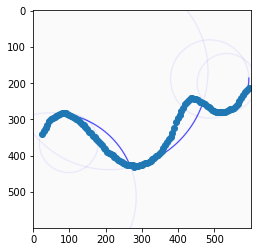

In [576]:
image, surface = draw_image(all_points, connections, (600, 600, 4), 1)

surface.write_to_png("easy_local.png")
plt.imshow(image)
plt.scatter(x, y)
# print(points)

## Contour walking method